# 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-4jusv9bf
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-4jusv9bf
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


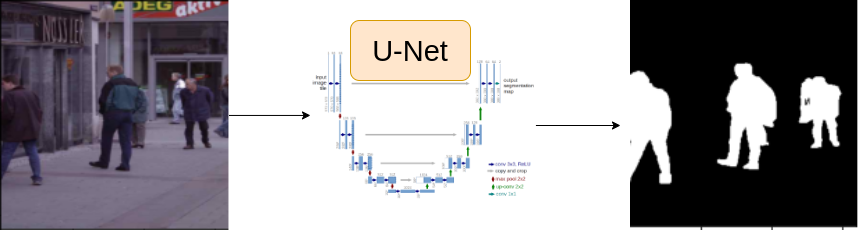

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# 2 : Setup Configurations

In [5]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[4]
image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

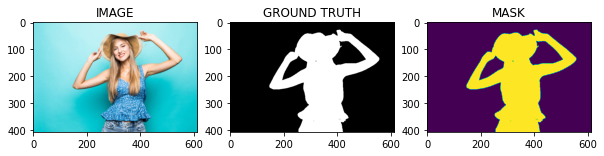

In [8]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

ax3.set_title('MASK')
ax3.imshow(mask)

In [9]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [11]:
def get_train_augs():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.HorizontalFlip(p = 0.5),
        A.VerticalFlip(p = 0.5)
    ])

def get_valid_augs():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE)
    ])

# 4 : Create Custom Dataset 

In [30]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):

    def __init__(self, df, augmentations):

        self.df = df
        self.augmentations = augmentations

    def __len__(self): 
        return(len(self.df))
    
    def __getitem__(self, idx):
        row = df.iloc[idx]

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h, w, c)
        mask = np.expand_dims(mask, axis= -1)

        if self.augmentations:
            data = self.augmentations(image = image, mask = mask)
            image = data['image']
            mask = data['mask']

        # (h, w, c) -> {c, h, w}
        image = np.transpose(image, (2,0,1)).astype(np.float32)
        mask = np.transpose(mask, (2,0,1)).astype(np.float32)

        image = torch.tensor(image) / 255.00
        mask = torch.tensor(mask) / 255.0


        return image, mask

In [14]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


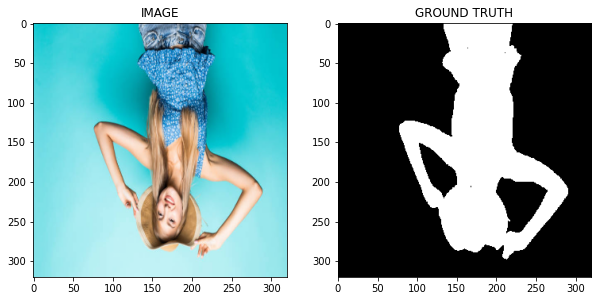

In [16]:
idx = 3

image, mask = trainset[idx]
helper.show_image(image, mask)

# 5 : Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [19]:
print(f"Total no. of batches in trainloader: {len(trainloader)}")
print(f"Total no. of batches in validloader: {len(validloader)}")

Total no. of batches in trainloader: 15
Total no. of batches in validloader: 4


In [20]:
for image, mask in trainloader:
    break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [21]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [22]:
class SegmentationModel(nn.Module):

    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.arc = smp.Unet(
            encoder_name = ENCODER,
            encoder_weights = WEIGHTS,
            in_channels = 3,
            classes = 1,
            activation = None,
        )

    def forward(self, images, masks = None):

        logits = self.arc(images)

        if masks != None:
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2

        return logits

In [23]:
model = SegmentationModel()
model.to(DEVICE);

# 7 : Create Train and Validation Function 

In [24]:
def train_fn(data_loader, model, optimizer):

    model.train()
    total_loss = 0

    for images, masks in tqdm(data_loader): #tqdm to track no. of batches

        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)



In [25]:
def eval_fn(data_loader, model):

    model.eval()
    total_loss = 0

    with torch.no_grad():
        for images, masks in tqdm(data_loader): #tqdm to track no. of batches

            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)

            total_loss += loss.item()

    return total_loss / len(data_loader)

# 8 : Train Model

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR) #learning rate = LR

In [27]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

    train_loss = train_fn(trainloader, model, optimizer)
    valid_loss = eval_fn(validloader, model)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        print("SAVED-MODEL")
        best_valid_loss = valid_loss

    print(f"EPOCH : {i+1} Train_loss : {train_loss} Valid_loss : {valid_loss}")

100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


SAVED-MODEL
EPOCH : 1 Train_loss : 0.3867705057064692 Valid_loss : 0.28255003690719604


100%|██████████| 4/4 [00:00<00:00,  4.56it/s]


SAVED-MODEL
EPOCH : 2 Train_loss : 0.06406481042504311 Valid_loss : 0.09505864977836609


100%|██████████| 4/4 [00:00<00:00,  4.61it/s]


SAVED-MODEL
EPOCH : 3 Train_loss : 0.029475244879722595 Valid_loss : 0.029659838881343603


100%|██████████| 4/4 [00:00<00:00,  4.60it/s]


SAVED-MODEL
EPOCH : 4 Train_loss : 0.0209425650537014 Valid_loss : 0.024574809707701206


100%|██████████| 4/4 [00:00<00:00,  4.60it/s]


SAVED-MODEL
EPOCH : 5 Train_loss : 0.017289266486962638 Valid_loss : 0.01937823835760355


100%|██████████| 4/4 [00:00<00:00,  4.59it/s]


SAVED-MODEL
EPOCH : 6 Train_loss : 0.014835811840991179 Valid_loss : 0.019047603011131287


100%|██████████| 4/4 [00:00<00:00,  4.59it/s]


SAVED-MODEL
EPOCH : 7 Train_loss : 0.013361167597273986 Valid_loss : 0.013629446504637599


100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


SAVED-MODEL
EPOCH : 8 Train_loss : 0.012404065889616808 Valid_loss : 0.012656260281801224


100%|██████████| 4/4 [00:00<00:00,  4.63it/s]


SAVED-MODEL
EPOCH : 9 Train_loss : 0.01220987799266974 Valid_loss : 0.011198548367246985


100%|██████████| 4/4 [00:00<00:00,  4.62it/s]


EPOCH : 10 Train_loss : 0.010167332117756207 Valid_loss : 0.012403888627886772


100%|██████████| 4/4 [00:00<00:00,  4.57it/s]


SAVED-MODEL
EPOCH : 11 Train_loss : 0.008603531743089358 Valid_loss : 0.009844111278653145


100%|██████████| 4/4 [00:00<00:00,  4.66it/s]


SAVED-MODEL
EPOCH : 12 Train_loss : 0.007630940526723862 Valid_loss : 0.009312190348282456


100%|██████████| 4/4 [00:00<00:00,  4.57it/s]


SAVED-MODEL
EPOCH : 13 Train_loss : 0.0068313110619783405 Valid_loss : 0.006927203969098628


100%|██████████| 4/4 [00:00<00:00,  4.56it/s]


SAVED-MODEL
EPOCH : 14 Train_loss : 0.00605508874480923 Valid_loss : 0.005732068791985512


100%|██████████| 4/4 [00:00<00:00,  4.58it/s]


EPOCH : 15 Train_loss : 0.0054863969484965 Valid_loss : 0.006011725170537829


100%|██████████| 4/4 [00:00<00:00,  4.58it/s]


EPOCH : 16 Train_loss : 0.004834422500183185 Valid_loss : 0.005967737291939557


100%|██████████| 4/4 [00:00<00:00,  4.60it/s]


SAVED-MODEL
EPOCH : 17 Train_loss : 0.004873936033497254 Valid_loss : 0.005154669983312488


100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


SAVED-MODEL
EPOCH : 18 Train_loss : 0.004490230558440089 Valid_loss : 0.003945569158531725


100%|██████████| 4/4 [00:00<00:00,  4.60it/s]


SAVED-MODEL
EPOCH : 19 Train_loss : 0.003679044373954336 Valid_loss : 0.003655897278804332


100%|██████████| 4/4 [00:00<00:00,  4.54it/s]


SAVED-MODEL
EPOCH : 20 Train_loss : 0.003282598173245788 Valid_loss : 0.0029362296918407083


100%|██████████| 4/4 [00:00<00:00,  4.63it/s]


SAVED-MODEL
EPOCH : 21 Train_loss : 0.0031035675201565027 Valid_loss : 0.0029146209126338363


100%|██████████| 4/4 [00:00<00:00,  4.60it/s]


SAVED-MODEL
EPOCH : 22 Train_loss : 0.0024899286994089684 Valid_loss : 0.0023087566951289773


100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


EPOCH : 23 Train_loss : 0.0022823600098490714 Valid_loss : 0.0036955245304852724


100%|██████████| 4/4 [00:00<00:00,  4.53it/s]


SAVED-MODEL
EPOCH : 24 Train_loss : 0.0034435111408432323 Valid_loss : 0.002129492291714996


100%|██████████| 4/4 [00:00<00:00,  4.63it/s]


SAVED-MODEL
EPOCH : 25 Train_loss : 0.0022165332377577823 Valid_loss : 0.001877706265076995


# 9 : Inference

In [28]:
idx = 2

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

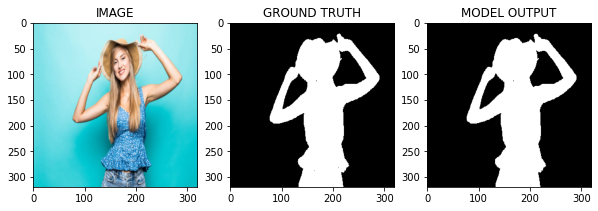

In [29]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))